In [1]:
from ckanapi import RemoteCKAN
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from pandas.io.json import json_normalize

ua = 'avoindata_ckanapi_example/1.0 ({0})'
ckan = RemoteCKAN('https://beta.avoindata.fi/data/fi/', user_agent=ua)
packages = ckan.action.package_search(q='Kansaneläkelaitos', fq = 'title:työttömyysturvaetuuksien')
resources = packages['results'][0]['resources'] 
url_csv = resources[0]['url']
url_json = resources[1]['url']
dat = pd.read_csv(url_csv, sep = ';', decimal = ',')

In [2]:
response = urlopen(url_json)
meta = json.loads(response.read())

## Datan ja metadatan kuvailu

**Datan kuvaustieto**

In [3]:
print(meta['description'])

Raportilla on Suomen työttömyysturvaetuuksien saajat, maksetut etuudet sekä korvatut päivät tilastointiajanjakson aikana. Euroa/päivä-tieto on laskettu jakamalla maksetut etuudet korvatuilla päivillä. Raportilla on sekä työttömyyskassojen maksamat ansioturvan etuudet että Kelan maksamat perusturvan etuudet. Korvausperusteluokitus jakaa etuudet työttömyysajalta ja aktiivitoimenpiteen ajalta maksettuihin etuuksiin. Vuorottelukorvaukset ovat luokassa 'Muu peruste'. Tieto puuttuu -luokkaan on tilastoitu Kelan etuuksien palautukset, joille ei tiedetä korvausperustetta. Huomattavaa: Työttömyyspäivärahoja alettiin maksaa aktiivitoimenpiteiden ajalta vuodesta 2010 alkaen.


**Datan muuttujatieto**

In [4]:
json_normalize(meta['resources'][0]['schema']['fields'])

,format,name,type,values
0,default,kuntanumero,integer,"[5, 9, 10, 16, 18, 19, 20, 35, 43, 46, 47, 49,..."
1,default,kunta,string,"[Alajärvi, Alavieska, Alavus, Asikkala, Askola..."
2,default,aikajakso,string,vuosi
3,default,etuuslaji,string,"[Yhteensä, Ansioturva yhteensä, Ansiopäiväraha..."
4,default,korvausperuste,string,"[Yhteensä, Työttömyyden perusteella]"
5,default,sukupuoli,string,Yhteensä
6,default,ikaryhma,string,Yhteensä
7,default,saajat,number,"[4, 47203]"
8,default,maksetut_etuudet_euroa,number,"[-34096, 999983]"
9,default,korvatut_paivat,number,"[-136, 999040]"


**Datan ensimmäiset rivit**

In [5]:
print(dat.head())

   kuntanumero      kunta aikajakso etuuslaji            korvausperuste  \
0            5   Alajärvi     vuosi  Yhteensä                  Yhteensä   
1            5   Alajärvi     vuosi  Yhteensä  Työttömyyden perusteella   
2            9  Alavieska     vuosi  Yhteensä                  Yhteensä   
3            9  Alavieska     vuosi  Yhteensä  Työttömyyden perusteella   
4           10     Alavus     vuosi  Yhteensä                  Yhteensä   

  sukupuoli  ikaryhma  saajat  maksetut_etuudet_euroa  korvatut_paivat  \
0  Yhteensä  Yhteensä     NaN                     NaN         186371.0   
1  Yhteensä  Yhteensä     NaN                     NaN         152208.0   
2  Yhteensä  Yhteensä     NaN                     NaN          38092.0   
3  Yhteensä  Yhteensä     NaN                907594.0          33308.0   
4  Yhteensä  Yhteensä     NaN                     NaN         191112.0   

   euroa_paiva  vuosi  kuukausi  
0        27.04   2000       NaN  
1        26.91   2000       NaN  
2 

In [6]:
plotdat = (dat
 .query('aikajakso == "vuosi"')
 .query('vuosi == "2018"')
 .query('etuuslaji == "Ansiopäiväraha"')
 .query('korvausperuste == "Yhteensä"')
 .query('sukupuoli == "Yhteensä"')
 .sort_values(by='euroa_paiva', ascending=False)
 .head(20))

#plt.bar(plotdat, height = )

## Kuvio

<BarContainer object of 20 artists>

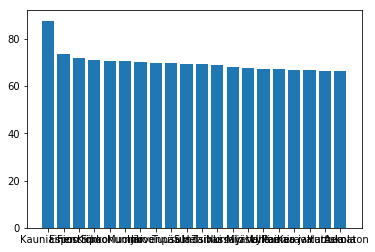

In [7]:
plt.bar(plotdat['kunta'], plotdat['euroa_paiva'])

## Datastore-api

Jos et tarvitse koko aineistoa, voit suodattaa siitä osio SQL:llä käyttäen CKAN:n DataStore-rajapintaa.

Alla olevassa esimerkissä tehdään rajaus `kunta`-muuttujasta ja siis etsitään vaan kuntaa *Veteli* koskevat tiedot.

In [8]:
kunta = "Veteli"
taulu = resources[0]['id']
muuttuja = 'kunta'
urli = f'https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from "{taulu}" WHERE {muuttuja} LIKE \'{kunta}\''
urli_plain = f'https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from "{taulu}"'
#urli = "https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from \"%s\" WHERE %s LIKE '%s'" % (taulu, muuttuja, kunta)
#urli_plain = "https://beta.avoindata.fi/data/fi/data/api/3/action/datastore_search_sql?sql=SELECT * from \"%s\"" % (taulu)
response = urlopen(urli_plain)
da = json.loads(response.read())
dataa = json_normalize(da['result']['records'])
#dataa
print(dataa.head())

                                          _full_text  _id aikajakso etuuslaji  \
0  '04':12 '186371':10 '2000':13 '27':11 '5':1 'a...    1     vuosi  Yhteensä   
1  '152208':11 '2000':14 '26':12 '5':1 '91':13 'a...    2     vuosi  Yhteensä   
2  '2000':13 '27':11 '34':12 '38092':10 '9':1 'al...    3     vuosi  Yhteensä   
3  '2000':14 '25':13 '27':12 '33308':11 '9':1 '90...    4     vuosi  Yhteensä   
4  '10':1 '191112':10 '2000':13 '26':11,12 'alavu...    5     vuosi  Yhteensä   

  euroa_paiva  ikaryhma korvatut_paivat            korvausperuste      kunta  \
0       27,04  Yhteensä          186371                  Yhteensä   Alajärvi   
1       26,91  Yhteensä          152208  Työttömyyden perusteella   Alajärvi   
2       27,34  Yhteensä           38092                  Yhteensä  Alavieska   
3       27,25  Yhteensä           33308  Työttömyyden perusteella  Alavieska   
4       26,26  Yhteensä          191112                  Yhteensä     Alavus   

  kuntanumero kuukausi maksetut_